In [1]:
!pip install -q google-cloud-bigquery google-cloud-bigquery-storage db-dtypes pandas pyarrow
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
from google.colab import auth
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
auth.authenticate_user()
print('Authenticated')
project_id = 'grounded-nebula-454917-r9' #@param {type: "string"}
# Set the default project id for %bigquery magic
magics.context.project = project_id
client = bigquery.Client(project=project_id)

Authenticated


In [3]:
%load_ext google.cloud.bigquery

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


#**MACHINE EVENTS TABLE DATA** -

In [4]:
%%bigquery machine_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events

Query is running:   0%|          |

Downloading:   0%|          |

#**MACHINE EVENTS TABLE INSIGHTS** -

In [5]:
%%bigquery machine_events_insights
SELECT capacity.cpus AS cpu_cap, capacity.memory AS memory_cap, COUNT(DISTINCT machine_id) AS num_machines
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events GROUP BY 1,2

Query is running:   0%|          |

Downloading:   0%|          |

#**COLLECTION EVENTS TABLE DATA** -

In [6]:
%%bigquery collection_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.collection_events

Query is running:   0%|          |

Downloading:   0%|          |

#**COLLECTION EVENTS TABLE INSIGHTS** -

In [7]:
%%bigquery collection_events_insights
SELECT COUNT(DISTINCT collection_id) AS collections FROM
`google.com:google-cluster-data`.clusterdata_2019_a.collection_events

Query is running:   0%|          |

Downloading:   0%|          |

#**INSTANCE EVENTS TABLE DATA** -

In [8]:
%%bigquery instance_events_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_events LIMIT 10000000

Query is running:   0%|          |

Downloading:   0%|          |

#**MACHINE ATTRIBUTES TABLE DATA** -

In [9]:
%%bigquery machine_attributes_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_attributes

Query is running:   0%|          |

Downloading:   0%|          |

#**INSTANCE USAGE DATA** -

In [10]:
%%bigquery instance_usage_data
SELECT * FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_usage LIMIT 10000000

Query is running:   0%|          |

Downloading:   0%|          |

# **DataFrames -**
machine_events_data, machine_events_insights, collection_events_data, collection_events_insights, instance_events_data, machine_attributes_data

In [11]:
# machine_events_data = machine_events_data.drop(columns=['switch_id', 'platform_id', 'missing_data_reason'], errors='ignore')
# machine_events_data = machine_events_data.dropna(subset=['machine_id'])
# machine_events_data = machine_events_data.dropna(subset=['capacity'])

machine_events_data['machine_id'].value_counts()[lambda x: x > 1]
machine_events_data

,time,machine_id,type,switch_id,capacity,platform_id,missing_data_reason
0,1687655299440,385611578151,1,+1VWJQsXJiHPTnLfEiJRudzQxErmdD00l4Iwh+Z/MYA=,None,JQ1tVQBMHBAIISU1gUNXk2powhYumYA+4cB3KzU29l8=,<NA>
1,90134737257,375997586330,1,+MID0TPk5AtCYpEsp9KxczyeufvrlAO6fiXWiUht754=,None,JQ1tVQBMHBAIISU1gUNXk2powhYumYA+4cB3KzU29l8=,<NA>
2,90077226715,375997549382,1,+MID0TPk5AtCYpEsp9KxczyeufvrlAO6fiXWiUht754=,None,JQ1tVQBMHBAIISU1gUNXk2powhYumYA+4cB3KzU29l8=,<NA>
3,89656654754,375996998784,1,+MID0TPk5AtCYpEsp9KxczyeufvrlAO6fiXWiUht754=,None,JQ1tVQBMHBAIISU1gUNXk2powhYumYA+4cB3KzU29l8=,<NA>
4,134215020545,376623426086,1,+MID0TPk5AtCYpEsp9KxczyeufvrlAO6fiXWiUht754=,None,JQ1tVQBMHBAIISU1gUNXk2powhYumYA+4cB3KzU29l8=,<NA>
...,...,...,...,...,...,...,...
46214,2294902521428,398063445417,3,tJpoO/kwxcx/l7ik925Tc+OmLQLyUbw6c1CjlKWZWp0=,"{'cpus': 0.591796875, 'memory': 0.33349609375}",ab11I4qQr/9Dkmo3M2CCSSHPkOU1S1Cb1p3rphUUjS8=,<NA>
46215,2374544210585,398963927990,3,tJpoO/kwxcx/l7ik925Tc+OmLQLyUbw6c1CjlKWZWp0=,"{'cpus': 0.591796875, 'memory': 0.33349609375}",ab11I4qQr/9Dkmo3M2CCSSHPkOU1S1Cb1p3rphUUjS8=,<NA>
46216,1689220940652,385613830661,3,yO20dDa8iSbq5ebU7smg72HuimYZ4UcvlqDOQEkPr1A=,"{'cpus': 0.591796875, 'memory': 0.33349609375}",ab11I4qQr/9Dkmo3M2CCSSHPkOU1S1Cb1p3rphUUjS8=,<NA>
46217,1963973255182,394444272211,3,4ongYKDcXk4K85v9NNJYKFOgQoDYx2i5rN2HqJ2PU4w=,"{'cpus': 0.591796875, 'memory': 0.33349609375}",ab11I4qQr/9Dkmo3M2CCSSHPkOU1S1Cb1p3rphUUjS8=,<NA>


In [12]:
# Getting machine_id wise capacity for each machine
machine_data = machine_events_data[['machine_id', 'capacity']].drop_duplicates(subset=['machine_id'])
machine_data.columns = ['machine_id', 'alloc_resources']
machine_data.dropna(inplace=True)
machine_data

,machine_id,alloc_resources
459,92126449465,"{'cpus': 1.0, 'memory': 0.5}"
461,92065249319,"{'cpus': 1.0, 'memory': 0.5}"
463,92046587157,"{'cpus': 1.0, 'memory': 0.5}"
465,92048363107,"{'cpus': 1.0, 'memory': 0.5}"
467,92035409124,"{'cpus': 1.0, 'memory': 0.5}"
...,...,...
27763,1132589876,"{'cpus': 0.591796875, 'memory': 0.33349609375}"
27765,1145848856,"{'cpus': 0.591796875, 'memory': 0.33349609375}"
27767,1145898444,"{'cpus': 0.591796875, 'memory': 0.33349609375}"
27772,1944787075,"{'cpus': 0.591796875, 'memory': 0.33349609375}"


In [13]:
collection_events_data.head()

,time,type,collection_id,scheduling_class,missing_type,collection_type,priority,alloc_collection_id,user,collection_name,collection_logical_name,parent_collection_id,start_after_collection_ids,max_per_machine,max_per_switch,vertical_scaling,scheduler
0,2008902486397,2,395282425680,1,<NA>,0,200,<NA>,CrwIv7SwZJ9dZIFd/+FO8oOMg2SYfHjo8h+VHd9C9q0=,TARdfk/mEsrZ+iRWWCHk9tq34Sn/DF8QwO3Gl6ya40o=,VRgkoJmajxP1p8AMi0NvCTBk+CGgdRXzjMF9EyZZ1e4=,394572359501,[],<NA>,<NA>,2,0
1,2381562785905,0,398982014339,1,<NA>,0,200,<NA>,CrwIv7SwZJ9dZIFd/+FO8oOMg2SYfHjo8h+VHd9C9q0=,diM+eWT6HD9qQh3m7xRuU2KVDsJwwD1BOArCTumWdr8=,VRgkoJmajxP1p8AMi0NvCTBk+CGgdRXzjMF9EyZZ1e4=,394572359802,[],<NA>,<NA>,2,0
2,2554368693424,0,399849688189,1,<NA>,0,200,<NA>,CrwIv7SwZJ9dZIFd/+FO8oOMg2SYfHjo8h+VHd9C9q0=,NginwIJdQoL/MwcaMVvt6WyLjY0gEHsfoSAeAQySVEk=,VRgkoJmajxP1p8AMi0NvCTBk+CGgdRXzjMF9EyZZ1e4=,399484485040,[],<NA>,<NA>,2,0
3,9864432742,2,375042159354,1,<NA>,0,200,<NA>,CrwIv7SwZJ9dZIFd/+FO8oOMg2SYfHjo8h+VHd9C9q0=,TDA5xsgw2WHT1cbxmjsJB9p+EpQzhF2Q/g12WPPWVz8=,VRgkoJmajxP1p8AMi0NvCTBk+CGgdRXzjMF9EyZZ1e4=,374937412396,[],<NA>,<NA>,2,0
4,2575791388549,3,399932062778,1,<NA>,0,200,<NA>,CrwIv7SwZJ9dZIFd/+FO8oOMg2SYfHjo8h+VHd9C9q0=,08Wp1usKotQfgGIpjE39VktDqlVtldw8rc2KQVBEjR8=,VRgkoJmajxP1p8AMi0NvCTBk+CGgdRXzjMF9EyZZ1e4=,399893029463,[],<NA>,<NA>,2,0


In [26]:
instance_events_data = instance_events_data[['collection_id', 'machine_id', 'instance_index', 'resource_request']].copy()
instance_events_data.dropna(inplace=True)
instance_events_data.head()

,collection_id,machine_id,instance_index,resource_request
0,330587160469,19876820938,264,"{'cpus': 0.0230712890625, 'memory': 0.01898193..."
3,330587123387,1579656389,282,"{'cpus': 0.024505615234375, 'memory': 0.018981..."
5,330587123387,376470499477,1354,"{'cpus': 0.02301025390625, 'memory': 0.0189819..."
7,330587120885,24272711884,1375,"{'cpus': 0.01953125, 'memory': 0.01898193359375}"
8,330587133435,70536764520,1305,"{'cpus': 0.022918701171875, 'memory': 0.018981..."


In [27]:
instance_usage_data = instance_usage_data.drop(columns=['alloc_collection_id','alloc_instance_index','collection_type',
                                                        'assigned_memory'], errors='ignore')
instance_usage_data = instance_usage_data[['collection_id', 'instance_index', 'machine_id', 'average_usage']]
instance_usage_data.head()

,collection_id,instance_index,machine_id,average_usage
0,220585815556,33,73750478789,"{'cpus': 0.000324249267578125, 'memory': 0.000..."
1,10164024340,238,1579686811,"{'cpus': 0.0061492919921875, 'memory': 0.00076..."
2,4422663195,1120,24270896446,"{'cpus': 0.0006685256958007812, 'memory': 0.00..."
3,4422663195,147,92035061455,"{'cpus': 0.00048351287841796875, 'memory': 0.0..."
4,330587259428,1996,35872338424,"{'cpus': 0.028350830078125, 'memory': 0.010314..."


In [28]:
instance_data = pd.merge(instance_usage_data, instance_events_data, on=['instance_index', 'collection_id'], how='inner')
instance_data = instance_data.dropna(subset=['resource_request'])
instance_data.head()

,collection_id,instance_index,machine_id_x,average_usage,machine_id_y,resource_request
0,220585815556,33,73750478789,"{'cpus': 0.000324249267578125, 'memory': 0.000...",73750478789,"{'cpus': 0.00823974609375, 'memory': 0.0003175..."
1,4422663195,1120,24270896446,"{'cpus': 0.0006685256958007812, 'memory': 0.00...",24270896446,"{'cpus': 0.029052734375, 'memory': 0.004447937..."
2,330587259428,1996,35872338424,"{'cpus': 0.028350830078125, 'memory': 0.010314...",2448204179,"{'cpus': 0.022979736328125, 'memory': 0.001302..."
3,358741519657,74,92153473438,"{'cpus': 0.0103302001953125, 'memory': 0.00863...",2448173585,"{'cpus': 0.0114898681640625, 'memory': 0.00130..."
4,358741519657,74,92153473438,"{'cpus': 0.0103302001953125, 'memory': 0.00863...",290351594299,"{'cpus': 0.0114898681640625, 'memory': 0.00130..."


In [29]:
instance_data['cpus_util'] = instance_data['average_usage'].apply(lambda x: x['cpus'])
instance_data['mem_util'] = instance_data['average_usage'].apply(lambda x: x['memory'])

instance_data['cpus_req'] = instance_data['resource_request'].apply(lambda x: x['cpus'])
instance_data['mem_req'] = instance_data['resource_request'].apply(lambda x: x['memory'])
instance_data.head()

,collection_id,instance_index,machine_id_x,average_usage,machine_id_y,resource_request,cpus_util,mem_util,cpus_req,mem_req
0,220585815556,33,73750478789,"{'cpus': 0.000324249267578125, 'memory': 0.000...",73750478789,"{'cpus': 0.00823974609375, 'memory': 0.0003175...",0.000324,0.000227,0.008240,0.000318
1,4422663195,1120,24270896446,"{'cpus': 0.0006685256958007812, 'memory': 0.00...",24270896446,"{'cpus': 0.029052734375, 'memory': 0.004447937...",0.000669,0.004143,0.029053,0.004448
2,330587259428,1996,35872338424,"{'cpus': 0.028350830078125, 'memory': 0.010314...",2448204179,"{'cpus': 0.022979736328125, 'memory': 0.001302...",0.028351,0.010315,0.022980,0.001303
3,358741519657,74,92153473438,"{'cpus': 0.0103302001953125, 'memory': 0.00863...",2448173585,"{'cpus': 0.0114898681640625, 'memory': 0.00130...",0.010330,0.008636,0.011490,0.001303
4,358741519657,74,92153473438,"{'cpus': 0.0103302001953125, 'memory': 0.00863...",290351594299,"{'cpus': 0.0114898681640625, 'memory': 0.00130...",0.010330,0.008636,0.011490,0.001303


In [40]:
resources_machine_data_sum = instance_data.groupby('machine_id_x')[['cpus_util', 'mem_util', 'cpus_req', 'mem_req']].transform('mean')
resources_machine_data_sum['cpus_util_perc'] = (resources_machine_data_sum['cpus_util'] * 100) / resources_machine_data_sum['cpus_req']
resources_machine_data_sum['mem_util_perc'] = (resources_machine_data_sum['mem_util'] * 100) / resources_machine_data_sum['mem_req']
resources_machine_data_sum = resources_machine_data_sum[(resources_machine_data_sum['cpus_util_perc'] <= 100) &
                                                        (resources_machine_data_sum['mem_util_perc'] <= 100)]

resources_machine_data_sum

,cpus_util,mem_util,cpus_req,mem_req,cpus_util_perc,mem_util_perc
0,0.001698,0.001002,0.012509,0.002886,13.577803,34.703563
1,0.005769,0.003357,0.014081,0.014389,40.969733,23.333928
2,0.002475,0.001300,0.013012,0.003602,19.020316,36.103602
3,0.003059,0.001328,0.010751,0.004414,28.450194,30.088559
4,0.003059,0.001328,0.010751,0.004414,28.450194,30.088559
...,...,...,...,...,...,...
28176654,0.003735,0.001968,0.015590,0.004099,23.959542,48.021419
28176655,0.003735,0.001968,0.015590,0.004099,23.959542,48.021419
28176656,0.003735,0.001968,0.015590,0.004099,23.959542,48.021419
28176657,0.003230,0.001454,0.011101,0.005745,29.100505,25.308899


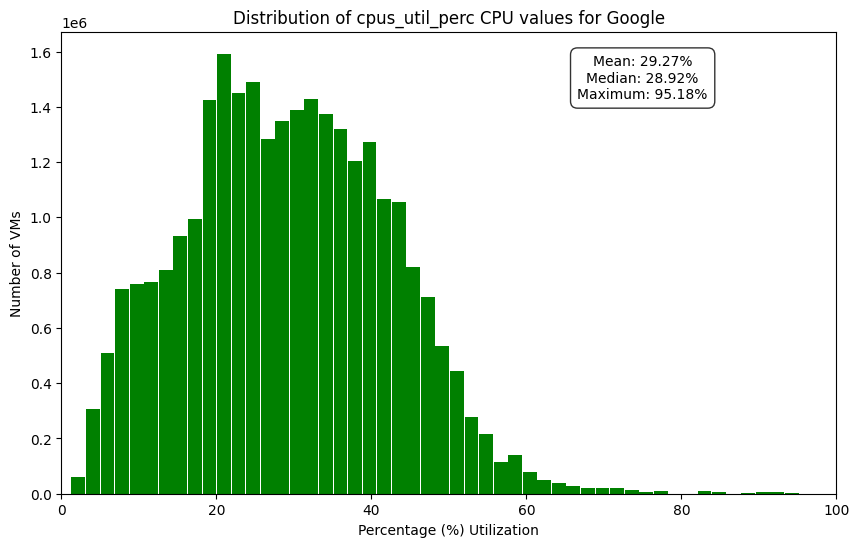

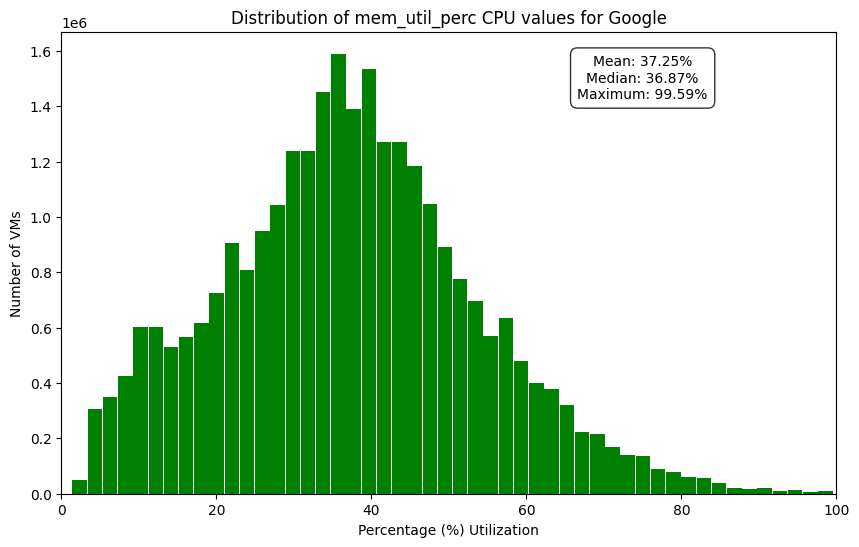

In [42]:
def plot_resource_analysis(dataframe, col_name):
    plt.figure(figsize = (10, 6))
    plt.hist(dataframe[col_name], bins = 50, rwidth = 0.95, color = "green")
    plt.title("Distribution of " + col_name + " CPU values for Google")
    plt.ylabel("Number of VMs")
    plt.xlabel("Percentage (%) Utilization")
    plt.xlim(0, 100)

    mean_val = dataframe[col_name].mean()
    median_val = dataframe[col_name].median()
    max_val = dataframe[col_name].max()

    stats_text = f"Mean: {mean_val:.2f}%\nMedian: {median_val:.2f}%\nMaximum: {max_val:.2f}%"
    plt.annotate(stats_text, xy=(0.75, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
                 va='top', ha='center', fontsize=10)

    plt.savefig(f'google_{col_name}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_resource_analysis(resources_machine_data_sum, 'cpus_util_perc')
plot_resource_analysis(resources_machine_data_sum, 'mem_util_perc')

In [21]:
cumu_trace_data = pd.merge(instance_data, machine_data, on='machine_id', how='inner')
cumu_trace_data.head()

KeyError: 'machine_id'

In [18]:
# unused_resources_machine_data = cumu_trace_data[['start_time','machine_id','average_usage', 'alloc_resources']]
# unused_resources_machine_data = unused_resources_machine_data[unused_resources_machine_data['average_usage'].apply(lambda x: x['cpus'] == 0.0 and x['memory'] == 0.0)]
# unused_resources_machine_data = unused_resources_machine_data.drop(columns=['average_usage'], errors='ignore')
# unused_resources_machine_data_sorted_by_time = unused_resources_machine_data.sort_values(by='start_time')
# unused_resources_machine_data_sorted_by_time

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import timedelta

# unused_resources_machine_data_sorted_by_time['cpus'] = unused_resources_machine_data_sorted_by_time['alloc_resources'].apply(lambda x: x['cpus'])
# unused_resources_machine_data_sorted_by_time['memory'] = unused_resources_machine_data_sorted_by_time['alloc_resources'].apply(lambda x: x['memory'])

# num_buckets = 50

# min_time = unused_resources_machine_data_sorted_by_time['start_time'].min()
# max_time = unused_resources_machine_data_sorted_by_time['start_time'].max()
# time_range = max_time - min_time
# bucket_size = time_range / num_buckets

# unused_resources_machine_data_sorted_by_time['time_bucket'] = ((unused_resources_machine_data_sorted_by_time['start_time'] - min_time) / bucket_size).astype(int)
# unused_resources_machine_data_sorted_by_time

In [20]:
# bucket_stats = unused_resources_machine_data_sorted_by_time.groupby('time_bucket').agg({
#     'cpus': 'mean','memory': 'mean','start_time': 'mean'
#     }).reset_index()

# fig, ax1 = plt.subplots(figsize=(12, 6))

# ax1.set_xlabel('Time Buckets')
# ax1.set_ylabel('Average CPU', color='tab:blue')
# ax1.plot(bucket_stats['time_bucket'], bucket_stats['cpus'], 'o-', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Average Memory', color='tab:red')
# ax2.plot(bucket_stats['time_bucket'], bucket_stats['memory'], 'o-', color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')

# plt.xticks(bucket_stats['time_bucket'])

# plt.title('Average Resource Usage by Time Bucket')
# fig.tight_layout()
# plt.savefig('resource_usage_by_time.png')
# plt.show()

In [23]:
resources_machine_data = cumu_trace_data[['start_time','machine_id','average_usage', 'alloc_resources']].copy()

resources_machine_data['cpus_util'] = resources_machine_data['average_usage'].apply(lambda x: x['cpus'])
resources_machine_data['mem_util'] = resources_machine_data['average_usage'].apply(lambda x: x['memory'])

resources_machine_data['cpus_alloc'] = resources_machine_data['alloc_resources'].apply(lambda x: x['cpus'])
resources_machine_data['mem_alloc'] = resources_machine_data['alloc_resources'].apply(lambda x: x['memory'])

resources_machine_data = resources_machine_data.drop(columns=['average_usage','alloc_resources'],errors='ignore')
resources_machine_data.head()

,start_time,machine_id,cpus_util,mem_util,cpus_alloc,mem_alloc
0,1734300000000,92139692575,0.017944,0.016479,1.000000,0.500000
1,1980600000000,72033836485,0.048157,0.017242,0.708984,0.333496
2,1764600000000,573288319,0.000360,0.000213,0.591797,0.333496
3,1261800000000,373226365437,0.000236,0.000217,0.708984,0.333496
4,2103000000000,80669054687,0.000144,0.000174,1.000000,0.500000


In [80]:
resources_machine_data_sum = resources_machine_data.groupby('machine_id')[['cpus_util', 'cpus_alloc']].transform('sum')
resources_machine_data['cpus_util_sum'] = resources_machine_data_sum['cpus_util']
resources_machine_data['cpus_alloc_sum'] = resources_machine_data_sum['cpus_alloc']

NameError: name 'resources_machine_data' is not defined

In [38]:
resources_machine_data['cpu_util_perc'] = (resources_machine_data['cpus_util'] / resources_machine_data['cpus_alloc']) * 100
resources_machine_data['mem_util_perc'] = (resources_machine_data['mem_util'] / resources_machine_data['mem_alloc']) * 100
resources_machine_data

,start_time,machine_id,cpus_util,mem_util,cpus_alloc,mem_alloc,cpu_util_perc,mem_util_perc
0,1734300000000,92139692575,0.017944,1.647949e-02,1.000000,0.500000,1.794434,3.295898
1,1980600000000,72033836485,0.048157,1.724243e-02,0.708984,0.333496,6.792355,5.170205
2,1764600000000,573288319,0.000360,2.126694e-04,0.591797,0.333496,0.060914,0.063770
3,1261800000000,373226365437,0.000236,2.174377e-04,0.708984,0.333496,0.033225,0.065199
4,2103000000000,80669054687,0.000144,1.735687e-04,1.000000,0.500000,0.014400,0.034714
...,...,...,...,...,...,...,...,...
9427488,2442698000000,35892263515,0.001106,6.504059e-04,0.708984,0.333496,0.156035,0.195027
9427489,2227524000000,4450923976,0.000288,3.509521e-04,0.591797,0.333496,0.048667,0.105234
9427490,2191071000000,35872325833,0.000000,9.536743e-07,0.708984,0.333496,0.000000,0.000286
9427491,876300000000,1579860143,0.000123,4.005432e-04,0.386719,0.166748,0.031812,0.240209


In [39]:
util_resources_machine_data = resources_machine_data[(resources_machine_data['cpu_util_perc'] <= 1) &
                                                (resources_machine_data['mem_util_perc'] <= 1)]

over_util_resources_machine_data = resources_machine_data[(resources_machine_data['cpu_util_perc'] > 1) |
                                                         (resources_machine_data['mem_util_perc'] > 1)]
count = len(over_util_resources_machine_data)
print(f"Number of rows where CPU or memory utilization is greater than 100%: {count}")

Number of rows where CPU or memory utilization is greater than 100%: 3471791


In [40]:
util_resources_machine_data['cpu_util_perc'].max()

np.float64(0.9996986914600551)

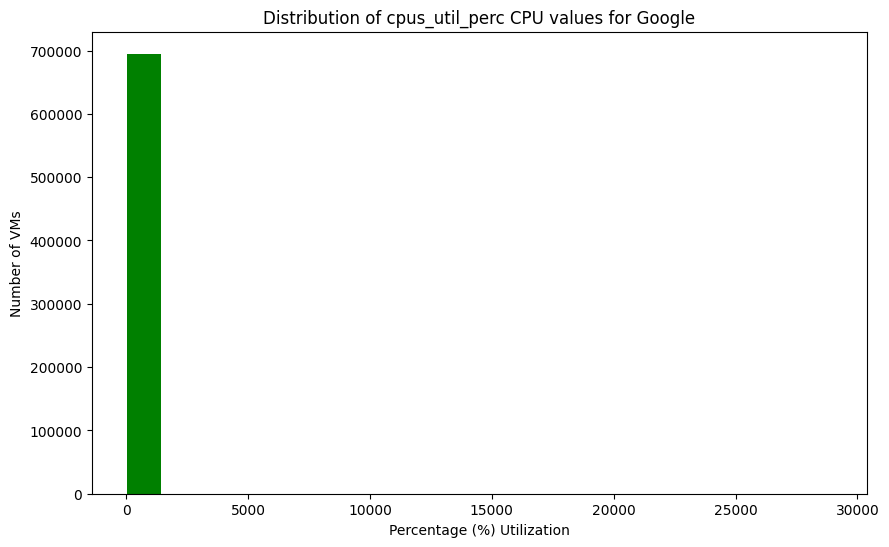

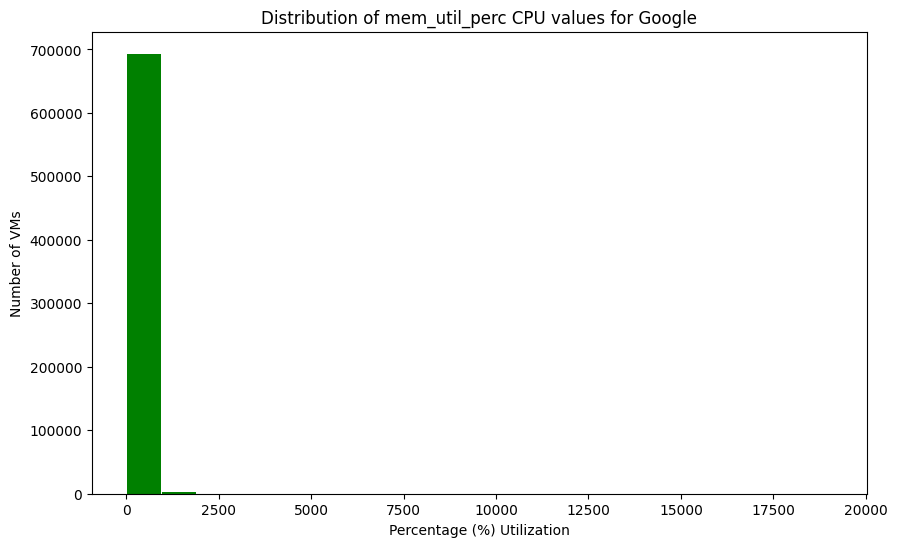

In [74]:
def plot_resource_analysis(dataframe, col_name):
    plt.figure(figsize = (10, 6))
    plt.hist(dataframe[col_name], bins = 20, rwidth = 0.95, color = "green")
    plt.title("Distribution of " + col_name + " CPU values for Google")
    plt.ylabel("Number of VMs")
    plt.xlabel("Percentage (%) Utilization")
    plt.show()

plot_resource_analysis(instance_data, 'cpus_util_perc')
plot_resource_analysis(instance_data, 'mem_util_perc')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import json
import re
from datetime import datetime

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort by start_time to ensure chronological order
df = df.sort_values('start_time')

# Extract CPU and memory values for easier plotting
df['cpu_alloc'] = df['alloc_resources'].apply(lambda x: x['cpus'])
df['memory_alloc'] = df['alloc_resources'].apply(lambda x: x['memory'])

# Convert timestamps to datetime for better X-axis formatting
# Assuming the timestamp is in milliseconds
df['datetime'] = pd.to_datetime(df['start_time'], unit='ms')

# Create figure and axis for plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for CPU allocation by time
ax1.plot(df['datetime'], df['cpu_alloc'], marker='o', linestyle='-', markersize=8, label='CPU Allocation')
ax1.set_ylabel('CPU Allocation')
ax1.set_title('CPU Resource Allocation Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot for Memory allocation by time
ax2.plot(df['datetime'], df['memory_alloc'], marker='s', linestyle='-', markersize=8, color='green', label='Memory Allocation')
ax2.set_ylabel('Memory Allocation')
ax2.set_xlabel('Start Time')
ax2.set_title('Memory Resource Allocation Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Format the x-axis to show dates nicely
plt.gcf().autofmt_xdate()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.savefig('resource_allocation_time_series.png', dpi=300, bbox_inches='tight')

# Create a combined scatter plot that shows both CPU and memory allocation
plt.figure(figsize=(12, 8))
plt.scatter(df['datetime'], df['cpu_alloc'], label='CPU', marker='o', s=100, alpha=0.7)
plt.scatter(df['datetime'], df['memory_alloc'], label='Memory', marker='s', s=100, alpha=0.7)

# Connect points chronologically
plt.plot(df['datetime'], df['cpu_alloc'], '--', alpha=0.4)
plt.plot(df['datetime'], df['memory_alloc'], '--', alpha=0.4)

plt.xlabel('Start Time')
plt.ylabel('Resource Allocation')
plt.title('CPU and Memory Resource Allocation Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig('combined_resource_allocation.png', dpi=300, bbox_inches='tight')

# Create a scatter plot with machine_id as color
plt.figure(figsize=(12, 8))

# Create a normalized color map based on machine_id
norm = plt.Normalize(df['machine_id'].min(), df['machine_id'].max())
scatter = plt.scatter(df['datetime'], df['cpu_alloc'],
                     c=df['machine_id'], cmap='viridis',
                     marker='o', s=df['memory_alloc']*200, alpha=0.7,
                     norm=norm, edgecolors='black')

# Add a color bar to show machine_id values
cbar = plt.colorbar(scatter)
cbar.set_label('Machine ID')

# Add annotations for the index values
for i, row in df.iterrows():
    plt.annotate(str(row['index']),
                (row['datetime'], row['cpu_alloc']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)

plt.xlabel('Start Time')
plt.ylabel('CPU Allocation')
plt.title('Resource Allocation by Machine (dot size = memory allocation)')
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.savefig('resource_allocation_by_machine.png', dpi=300, bbox_inches='tight')

# Create a box plot to show the distribution of resource allocations
plt.figure(figsize=(10, 6))

# Create a DataFrame with CPU and Memory in separate columns for box plotting
box_data = pd.DataFrame({
    'CPU': df['cpu_alloc'],
    'Memory': df['memory_alloc']
})

# Create the box plot
box_data.boxplot(grid=True)
plt.ylabel('Resource Allocation')
plt.title('Distribution of Resource Allocations')

plt.tight_layout()
plt.savefig('resource_allocation_distribution.png', dpi=300, bbox_inches='tight')

# Print summary statistics
print("CPU Allocation Statistics:")
print(df['cpu_alloc'].describe())
print("\nMemory Allocation Statistics:")
print(df['memory_alloc'].describe())

# Return the sorted dataframe with the extracted values
print("\nSorted Data:")
print(df[['datetime', 'machine_id', 'cpu_alloc', 'memory_alloc']].head(10))

plt.show()

In [85]:
unused_machine_data[unused_machine_data['alloc_resources']]
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# sns.histplot(unused_machine_data['alloc_resources'], bins=50, kde=True, color='green')
# plt.xlabel('Allocated Resources')
# plt.ylabel('Frequency')
# plt.title('Distribution of Allocated Resources')
# plt.show()

,machine_id,average_usage,alloc_resources


In [ ]:
#@title Select a cell and a resource to plot the cell level usage series

def query_cell_capacity(cell):
  return '''
SELECT SUM(cpu_cap) AS cpu_capacity,
  SUM(memory_cap) AS memory_capacity
FROM (
  SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
    MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
  GROUP BY 1
)
  '''.format(cell=cell)

def query_per_instance_usage_priority(cell):
  return '''
SELECT u.time AS time,
  u.collection_id AS collection_id,
  u.instance_index AS instance_index,
  e.priority AS priority,
  CASE
    WHEN e.priority BETWEEN 0 AND 99 THEN '1_free'
    WHEN e.priority BETWEEN 100 AND 115 THEN '2_beb'
    WHEN e.priority BETWEEN 116 AND 119 THEN '3_mid'
    ELSE '4_prod'
  END AS tier,
  u.cpu_usage AS cpu_usage,
  u.memory_usage AS memory_usage
FROM (
  SELECT start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
) AS u JOIN (
  SELECT collection_id, instance_index, machine_id,
    MAX(priority) AS priority
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_events
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  GROUP BY 1, 2, 3
) AS e ON u.collection_id = e.collection_id
  AND u.instance_index = e.instance_index
  AND u.machine_id = e.machine_id
  '''.format(cell=cell)

def query_per_tier_utilization_time_series(cell, cpu_capacity, memory_capacity):
  return '''
SELECT CAST(FLOOR(time/(1e6 * 60 * 60)) AS INT64) AS hour_index,
  tier,
  SUM(cpu_usage) / (12 * {cpu_capacity}) AS avg_cpu_usage,
  SUM(memory_usage) / (12 * {memory_capacity}) AS avg_memory_usage
FROM ({table})
GROUP BY 1, 2 ORDER BY hour_index
  '''.format(table=query_per_instance_usage_priority(cell),
             cpu_capacity=cpu_capacity, memory_capacity=memory_capacity)

def run_query_utilization_per_time_time_series(cell):
  cell_cap = client.query(query_cell_capacity(cell)).to_dataframe()
  query = query_per_tier_utilization_time_series(
      cell,
      cell_cap['cpu_capacity'][0],
      cell_cap['memory_capacity'][0])
  time_series = client.query(query).to_dataframe()
  return time_series

cell = 'a' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
hourly_usage = run_query_utilization_per_time_time_series(cell)

# filtered_hourly_usage = hourly_usage[hourly_usage[cell] <= 40]

# CPU graph
cpu = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_cpu_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_cpu_usage']
  )
cpu.encoding.x.title = "Hour"
cpu.encoding.y.title = "Average CPU usage"
cpu.display()

# Memory graph
memory = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_memory_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_memory_usage']
  )
memory.encoding.x.title = "Hour"
memory.encoding.y.title = "Average memory usage"
memory.display()

alt.Chart(...)

alt.Chart(...)

In [ ]:
#@title Select a cell and plot its per-machine resource utilization CDFs
# Functions to plot CDFs using Altair
def pick_quantiles_from_tall_dataframe(data, qcol, name=""):
  quantiles = pd.DataFrame([x for x in data[qcol]]).transpose()
  if name != "":
    quantiles.columns = data[name]
  return quantiles

# - data: a dataframe with one row and one or more columns of quantiles (results
#   returned from APPROX_QUANTILES)
# - qcols: a list of names of the quantiles
# - names: the names of each returned quantiles' columns.
def pick_quantiles_from_wide_dataframe(data, qcols, names=[]):
  quantiles = {}
  i = 0
  for qcol in qcols:
    col_name = qcol
    if i < len(names):
      col_name = names[i]
    quantiles[col_name] = data[qcol][0]
    i+=1
  return pd.DataFrame(quantiles)

# - quantiles: a dataframe where each column contains the quantiles of one
#   data set. The index (i.e. row names) of the dataframe is the quantile. The
#   column names are the names of the data set.
def plot_cdfs(quantiles, xlab="Value", ylab="CDF",
              legend_title="dataset", labels=[],
              interactive=False,
              title=''):
  dfs = []
  label = legend_title
  yval = range(quantiles.shape[0])
  esp = 1.0/(len(quantiles)-1)
  yval = [y * esp for y in yval]
  while label == xlab or label == ylab:
    label += '_'
  for col_idx, col in enumerate(quantiles.columns):
    col_label = col
    if col_idx < len(labels):
      col_label = labels[col_idx]
    dfs.append(pd.DataFrame({
        label: col_label,
        xlab: quantiles[col],
        ylab: yval
    }))
  cdfs = pd.concat(dfs)
  lines = alt.Chart(cdfs).mark_line().encode(
    # If you can draw a CDF, it has to be continuous real-valued
    x=xlab+":Q",
    y=ylab+":Q",
    color=label+":N"
  ).properties(
    title=title
  )
  if not interactive:
    return lines
  # Create a selection that chooses the nearest point & selects based on x-value
  nearest = alt.selection_point(nearest=True, on='mouseover',
                                fields=[ylab], empty='none')
  # Transparent selectors across the chart. This is what tells us
  # the y-value of the cursor
  selectors = alt.Chart(cdfs).mark_point().encode(
    y=ylab+":Q",
    opacity=alt.value(0),
  ).add_params(nearest)

  # Draw text labels near the points, and highlight based on selection
  text = lines.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest,
                       alt.Text(xlab+":Q", format=".2f"),
                       alt.value(' '))
  )

  # Draw a rule at the location of the selection
  rules = alt.Chart(cdfs).mark_rule(color='gray').encode(
    y=ylab+":Q",
  ).transform_filter(
    nearest
  )
  # Draw points on the line, and highlight based on selection
  points = lines.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
  )
  # Put the five layers into a chart and bind the data
  return alt.layer(lines, selectors, rules, text, points).interactive(
      bind_y=False)

In [ ]:
# Functions to create the query

def query_machine_capacity(cell):
  return '''
SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
  MAX(capacity.memory) AS memory_cap
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
GROUP BY 1
  '''.format(cell=cell)

def query_top_level_instance_usage(cell):
  return '''
SELECT CAST(FLOOR(start_time/(1e6 * 300)) * (1000000 * 300) AS INT64) AS time,
  collection_id,
  instance_index,
  machine_id,
  average_usage.cpus AS cpu_usage,
  average_usage.memory AS memory_usage
FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  AND (end_time - start_time) >= (5 * 60 * 1e6)
  '''.format(cell=cell)

def query_machine_usage(cell):
  return '''
SELECT u.time AS time,
  u.machine_id AS machine_id,
  SUM(u.cpu_usage) AS cpu_usage,
  SUM(u.memory_usage) AS memory_usage,
  MAX(m.cpu_cap) AS cpu_capacity,
  MAX(m.memory_cap) AS memory_capacity
FROM ({instance_usage}) AS u JOIN
 ({machine_capacity}) AS m
ON u.machine_id = m.machine_id
GROUP BY 1, 2
  '''.format(instance_usage = query_top_level_instance_usage(cell),
             machine_capacity = query_machine_capacity(cell))

def query_machine_utilization_distribution(cell):
  return '''
SELECT APPROX_QUANTILES(IF(cpu_usage > cpu_capacity, 1.0, cpu_usage / cpu_capacity), 100) AS cpu_util_dist,
  APPROX_QUANTILES(IF(memory_usage > memory_capacity, 1.0, memory_usage / memory_capacity), 100) AS memory_util_dist
FROM ({table})
  '''.format(table = query_machine_usage(cell))

cell = 'a' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
query = query_machine_utilization_distribution(cell)
machine_util_dist = client.query(query).to_dataframe()
plot_cdfs(pick_quantiles_from_wide_dataframe(machine_util_dist, ['cpu_util_dist', 'memory_util_dist'], ['CPU', 'Memory']), xlab='x - resource utilization (%)', ylab="Probability (resource utilization < x)", interactive=True)


alt.LayerChart(...)